<a href="https://colab.research.google.com/github/DineshChopra/AI-ML/blob/master/TensorFlow/Udacity/8_8_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with LSTM

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [25]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

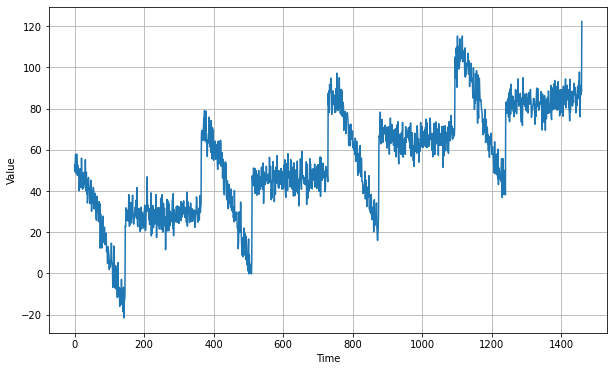

In [26]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [27]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## LSTM RNN Forecasting

In [28]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [29]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [30]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, 
                         stateful=True, 
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
  lambda epoch: 1e-8 * 10**(epoch / 30))

reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 83.9873 - mae: 84.4873
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 75.9798 - mae: 76.4798
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 67.3260 - mae: 67.8260
Epoch 5/100
33/33 [==============================] - 0s 6ms/step - loss: 57.9995 - mae: 58.4995
Epoch 6/100
33/33 [==============================] - 0s 6ms/step - loss: 47.9742 - mae: 48.4741
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 37.2820 - mae: 37.7817
Epoch 8/100
33/33 [==============================] - 0s 6ms/step - loss: 25.9657 - mae: 26.4651
Epoch 9/100
33/33 [==============================] - 0s 6ms/step - loss: 15.1204 - mae: 15.6161
Epoch 10/100
33/33 [==============================] - 0s 6ms/step - loss: 10.1845 - mae: 10.6703
Epoch 11/100
33/33 [===================

(1e-08, 0.0001, 0.0, 30.0)

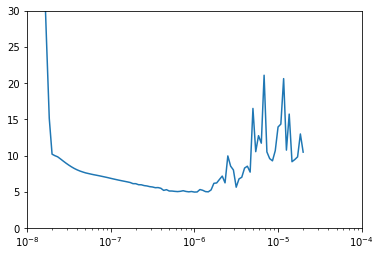

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [33]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True
)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs = 500,
          validation_data = valid_set,
          callbacks = [early_stopping, model_checkpoint, reset_states])


Epoch 1/500
33/33 [==============================] - 1s 27ms/step - loss: 71.8504 - mae: 72.3504 - val_loss: 70.8554 - val_mae: 71.3554
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 14.4849 - mae: 14.9745 - val_loss: 13.3052 - val_mae: 13.7990
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 15.5631 - mae: 16.0559 - val_loss: 23.1494 - val_mae: 23.6482
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 10.2731 - mae: 10.7654 - val_loss: 15.5669 - val_mae: 16.0616
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 10.8546 - mae: 11.3460 - val_loss: 16.5603 - val_mae: 17.0564
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 8.8267 - mae: 9.3163 - val_loss: 13.8636 - val_mae: 14.3576
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 8.2400 - mae: 8.7255 - val_loss: 12.8280 - val_mae: 13.3232
Epoch 8/500
33/33 [==============================] - 0s 9m

In [34]:
model = keras.models.load_model("my_checkpoint.h5")

In [35]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [36]:
rnn_forecast.shape

(461,)

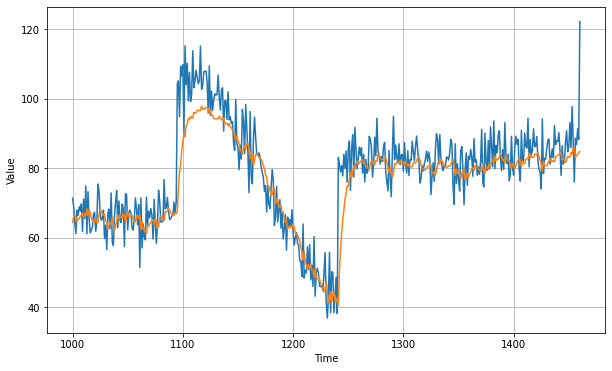

In [37]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [38]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4348063